In [43]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to c:\users\mehdi\appdata\local\temp\pip-req-build-6lz4iqkf
  Resolved https://github.com/albumentations-team/albumentations to commit 23b28cbaeaced9170a31f82e7e11b8f5dcab2b46
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations 'C:\Users\Mehdi\AppData\Local\Temp\pip-req-build-6lz4iqkf'


In [44]:
import torch
print(torch.__version__)

2.5.0+cu118


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [45]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


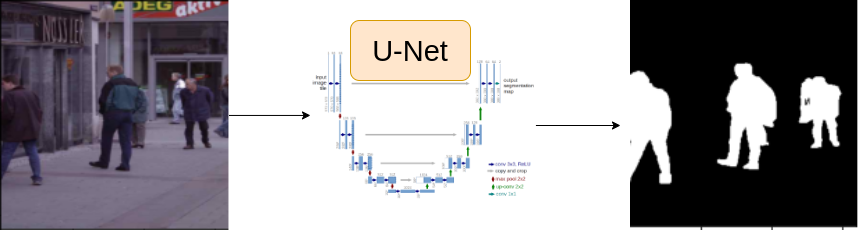

In [46]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [47]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [48]:
CSV_File = 'Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = 'Human-Segmentation-Dataset-master/'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [49]:
df = pd.read_csv(CSV_File)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [61]:
for i in range(25):
    row = df.iloc[i]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

    print(image.shape, mask.shape)

(183, 276, 3) (183, 276)
(183, 275, 3) (183, 275)
(1055, 1280, 3) (454, 551)
(505, 786, 3) (401, 624)
(408, 612, 3) (408, 612)
(243, 365, 3) (243, 365)
(195, 259, 3) (195, 259)
(479, 576, 3) (456, 548)
(458, 307, 3) (458, 307)
(440, 660, 3) (408, 612)
(500, 750, 3) (408, 612)
(300, 450, 3) (300, 450)
(168, 299, 3) (168, 299)
(500, 750, 3) (408, 612)
(640, 480, 3) (577, 433)
(640, 480, 3) (577, 433)
(640, 480, 3) (577, 433)
(640, 480, 3) (577, 433)
(640, 480, 3) (577, 433)
(640, 480, 3) (577, 433)
(640, 480, 3) (577, 433)
(640, 480, 3) (577, 433)
(640, 480, 3) (577, 433)
(168, 300, 3) (168, 300)
(640, 480, 3) (577, 433)


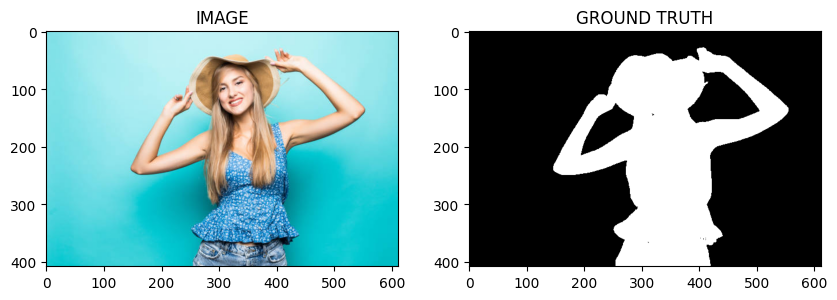

In [51]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [60]:
print(image.shape, mask.shape)

(408, 612, 3) (408, 612)


In [52]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [53]:
import albumentations as A

In [54]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE)
    ])

# Create Custom Dataset

In [55]:
from torch.utils.data import Dataset

In [62]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentation=None):
        self.df = df
        self.augmentation = augmentation
    
    def __len__(self):
        return len(self.df)
    
    def transform(self, image, mask):
        # Ensure the mask has the same size as the image
        if image.shape[:2] != mask.shape[:2]:
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        # Expand mask dimensions if needed (H, W) -> (H, W, 1)
        mask = np.expand_dims(mask, axis=-1)
        
        return image, mask

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Read images and masks
        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Check if image or mask is None
        if image is None or mask is None:
            raise FileNotFoundError(f"Could not load image or mask at index {idx}")

        # Convert image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply the pre-augmentation transform function
        image, mask = self.transform(image, mask)

        # Apply augmentations
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Reshape (H, W, C) -> (C, H, W)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        # Normalize
        image = torch.tensor(image) / 255.0
        mask = torch.round(torch.tensor(mask) / 255.0)

        return image, mask


In [63]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [64]:
print(f"Size of Trainset: {len(trainset)}")
print(f"Size of Validset: {len(validset)}")

Size of Trainset: 232
Size of Validset: 58


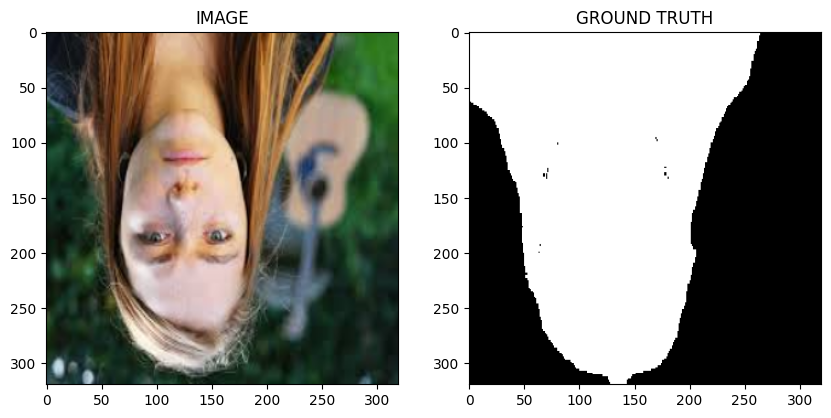

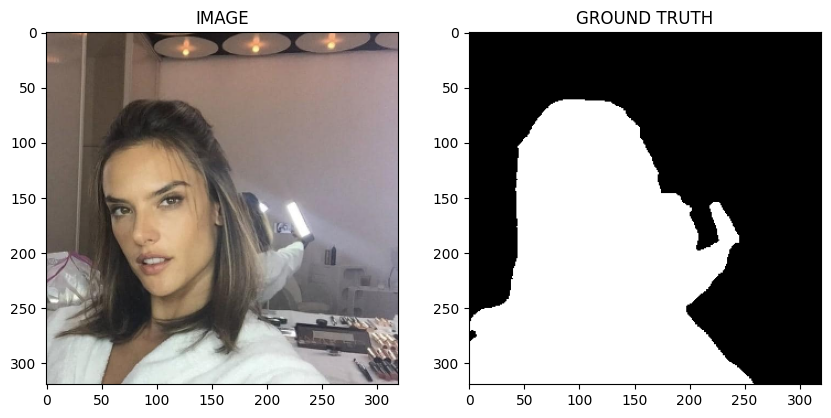

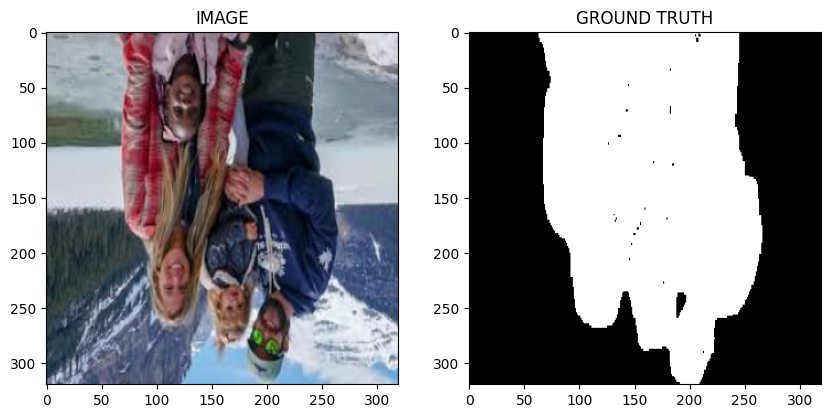

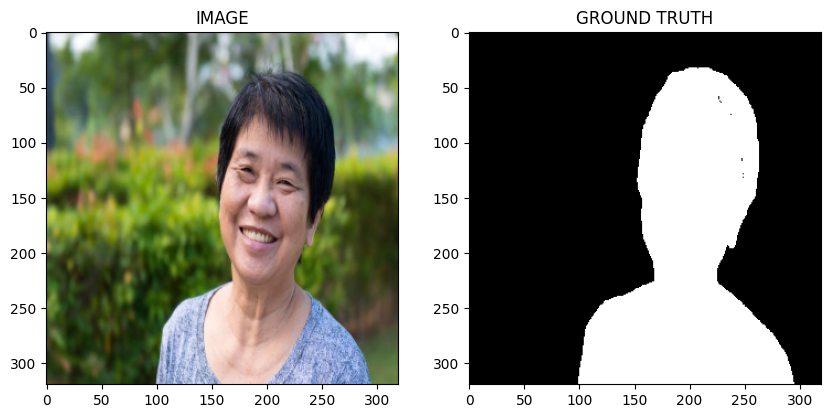

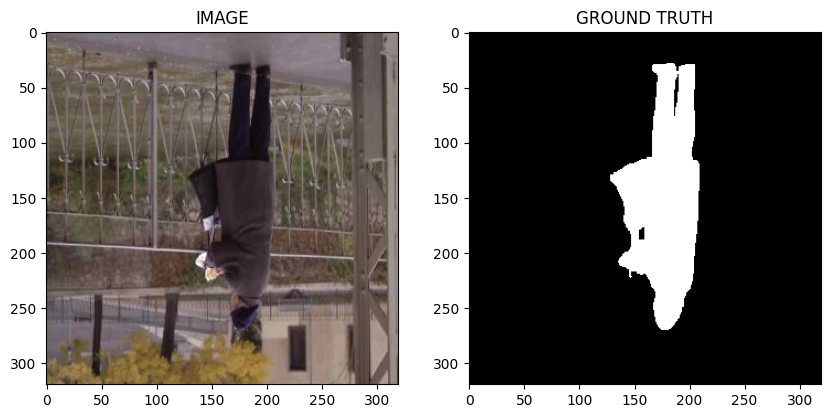

In [66]:
for i in range(5):
    image, mask = trainset[i]
    helper.show_image(image, mask)

# Load dataset into batches

In [67]:
import torch.utils.data as Dataloader

In [70]:
trainloader = Dataloader.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = Dataloader.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [71]:
print(f"Size of Trainloader: {len(trainloader)}")
print(f"Size of Validloader: {len(validloader)}")

Size of Trainloader: 15
Size of Validloader: 4


In [72]:
for image, mask in trainloader:
    print(image.shape, mask.shape)
    break

torch.Size([16, 3, 320, 320]) torch.Size([16, 1, 320, 320])


# Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [74]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [76]:
class SegmentationModel(nn.Module):

    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
    
    def forward(self, images, masks=None):
        logits = self.arc(images)

        if mask != None:
            loss1 = DiceLoss()(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

In [77]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to C:\Users\Mehdi/.cache\torch\hub\checkpoints\tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 11.4MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Create Train and Validation Function

In [78]:
def train_fn(data_loader, model, optimizer):
    
    model.train()
    total_loss = 0

    for images, masks in tqdm(data_loader):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [80]:
def eval_fn(data_loader, model):

    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss / len(data_loader)

# Task 8 : Train Model

# Task 9 : Inference

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya